<a href="https://colab.research.google.com/github/ParitoshP702/Volatality_Prediction_of_Stock_Prices/blob/main/Volatality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import yfinance as yf
import warnings
from numba import jit
warnings.filterwarnings('ignore')

In [ ]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2022,1,1)
stocks = "^GSPC"
sp500 = yf.download(stocks,start = start, end = end, interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Calulating the daily returns of sp500 stocks in percentage
ret = 100*sp500["Adj Close"].pct_change().dropna()

In [ ]:
#calculating the realized volatality over a rolling window of 5 trading days
realized_vol = ret.rolling(window = 5).std()

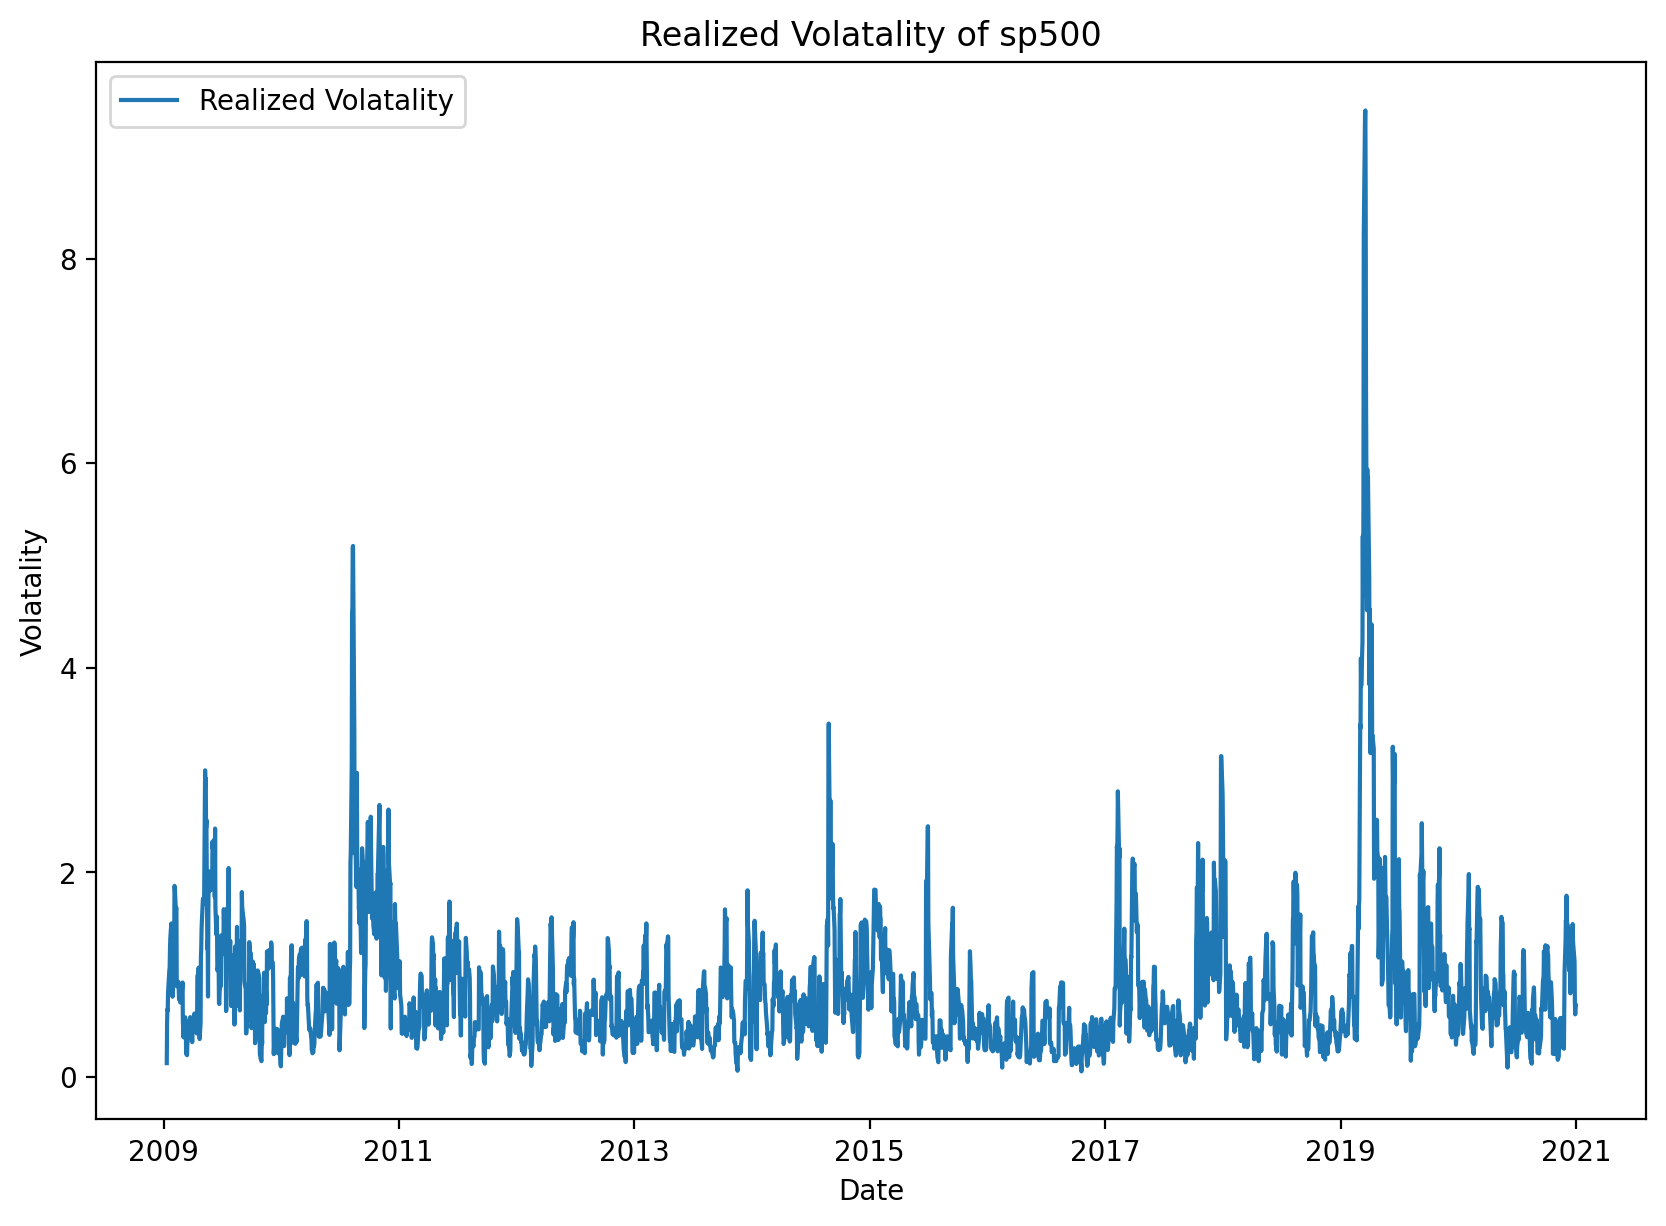

In [ ]:
#Plotting our realized volatality
plt.figure(figsize = (10,7), dpi = 200)
plt.plot(realized_vol.index, realized_vol.values, label = "Realized Volatality")
plt.xlabel("Date")
plt.ylabel("Volatality")
plt.title("Realized Volatality of sp500")
plt.legend(loc = "best");

Thus , we can see a huge spike in volatality during the covid-19 period

# Now we will use some classical volatality models to model the volatality of market returns. The first one is namely:
# ARCH Model

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.2 MB/s 


In [ ]:
from arch import arch_model
from scipy.stats import norm
import scipy.optimize as opt
import time

First we will build our own ARCH model using our own python code 

In [ ]:
retv = ret.values
n = 252
split_date = ret.iloc[-n:].index#defining the split location and assigning the split data to split variable


In [ ]:
#calculating the variance of sp500
sgm2 = ret.var()
K = ret.kurtosis()#calculating the kurtosis of sp500 stocks
#Now we will identify the initial values for slope coefficient alpha
alpha = (-3.0* sgm2+np.sqrt(9.0*sgm2**2-12.0*(3*sgm2-K)*K))/(6*K)
omega = (1-alpha)*sgm2#alculating the initial value for omega
initial_parameters = [omega,alpha] 

In [ ]:
omega,alpha

(0.6220166329614314, 0.46836884362969905)

In [ ]:
def arch_likelihood(intial_parameters, retv):
  omega = abs(initial_parameters[0])
  alpha = abs(initial_parameters[1])
  T = len(retv)
  logliks = 0
  sigma2 = np.zeros(T)
  sigma2[0] = np.var(retv)
  for t in range(1,T):
    sigma2[t] = omega + alpha*(retv[t-1])**2
  logliks = np.sum(0.5*(np.log(sigma2)+ retv**2/sigma2))
  return logliks  

In [ ]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1420.9345103216733

In [ ]:
#Now we will minimize the log likelihood function
def opt_params(x0,retv):
  opt_result = opt.minimize(arch_likelihood, x0 = x0, args = (retv), method = "Nelder-Mead", options = {'maxiter':5000})
  params = opt_result.x
  print("Result of Neldor-Mead minimization\n{}".format(opt_result))
  print("\nResulting params:{}".format(params))
  return params

In [ ]:
params = opt_params(initial_parameters, retv)

Result of Neldor-Mead minimization
 final_simplex: (array([[0.62201663, 0.46836884],
       [0.62207738, 0.46836884],
       [0.62201663, 0.46841458]]), array([1420.93451032, 1420.93451032, 1420.93451032]))
           fun: 1420.9345103216733
       message: 'Optimization terminated successfully.'
          nfev: 39
           nit: 10
        status: 0
       success: True
             x: array([0.62201663, 0.46836884])

Resulting params:[0.62201663 0.46836884]


In [ ]:
def arch_apply(ret):
  omega = params[0]
  alpha = params[1]
  T = len(ret)
  sigma2_arch = np.zeros(T+1)
  sigma2_arch[0] = np.var(ret)
  for t in range(1,T):
    sigma2_arch[t] = omega + alpha * ret[t-1]**2
  return sigma2_arch

In [ ]:
sigma2_arch = arch_apply(ret)

Now we will use the built in function for our arch model

In [ ]:
arch = arch_model(ret, mean = 'zero', vol = "ARCH", p = 1).fit(disp = "off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4190.99
Distribution:                  Normal   AIC:                           8385.99
Method:            Maximum Likelihood   BIC:                           8398.01
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:18   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6926  4.859e-02     14.255  4.196e-46 [  0.597,  0.78

Hence we can see that the results of our self built ARCH model and that of inbuilt functions are quite close

Now we need to define a proper information criteria , here we will use the Bayesian Information Criteria(BIC) for model selection to choose proper lag

In [ ]:
bic_arch = []
for p in range(1,5):
  arch = arch_model(ret, mean = "zero", vol = "ARCH", p =p).fit(disp = 'off')
  bic_arch.append(arch.bic)
  if arch.bic == np.min(bic_arch):
     best_param = p
arch = arch_model(ret, mean = "zero", vol = "ARCH", p = best_param).fit(disp = "off")
print(arch.summary())
forecast = arch.forecast(start = split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3834.05
Distribution:                  Normal   AIC:                           7678.09
Method:            Maximum Likelihood   BIC:                           7708.16
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:19   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2820  2.561e-02     11.012  3.356e-28   [  0.23

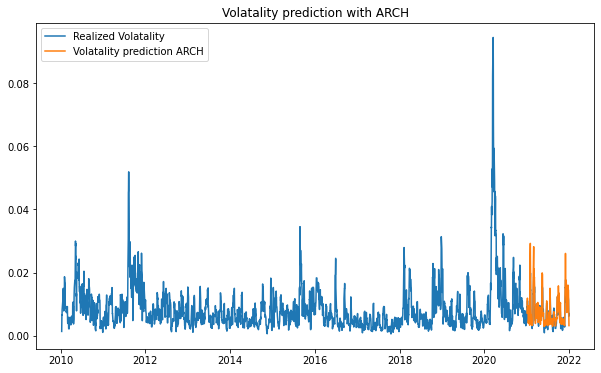

In [ ]:
from sklearn.metrics import mean_squared_error as mse
#Plotiing our predictions vs actual volatality
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(forecast_arch.variance.iloc[-len(split_date):]/100, label = "Volatality prediction ARCH")
plt.title("Volatality prediction with ARCH", fontsize = 12)
plt.legend();

Now we will forecast the volatality using another model , which is an enhanced version of the ARCH model, which also includes the lagged conditional variance terms in intself to account for its multivarible nature,namely:
# GARCH Model:

In [ ]:
garch = arch_model(ret, mean = "zero", vol = "GARCH", p = 1, o = 0, q = 1).fit(disp = "off")
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3780.03
Distribution:                  Normal   AIC:                           7566.05
Method:            Maximum Likelihood   BIC:                           7584.09
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:19   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0407  8.374e-03      4.864  1.151e-06 [2.

Now we are going to choose the appropriate value of lag parameters for returns and conditional variances using BIC(Bayesian Information Criteria)

In [ ]:
bic_garch = []
for p in range(1,5):
  for q in range(1,5):
    garch = arch_model(ret, mean = "zero", vol = "GARCH", p = p, q = q, o = 0).fit(disp = "off")
    bic_garch.append(garch.bic)
    if garch.bic == np.min(bic_garch):
      best_params = p,q
garch = arch_model(ret,mean = "zero", vol = "GARCH", p = best_params[0], q = best_params[1], o = 0).fit(disp = "off")
garch.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3780.03
Distribution:                  Normal   AIC:                           7566.05
Method:            Maximum Likelihood   BIC:                           7584.09
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:20   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0407  8.374e-03      4.864  1.151e-06 [2.432e-02,5.714e-02]
alpha[1]       0.1731  2.194e-02      7.889  3.036e-15     [  0.130,  0.216]
beta[1]        0.7879  2.219e-02     35.514 2.961e-276     [  0.744,  0.831]
============================================================================

Covariance estimator: robust
"""

In [ ]:
forecast = garch.forecast(start = split_date[0])
forecast_garch = forecast

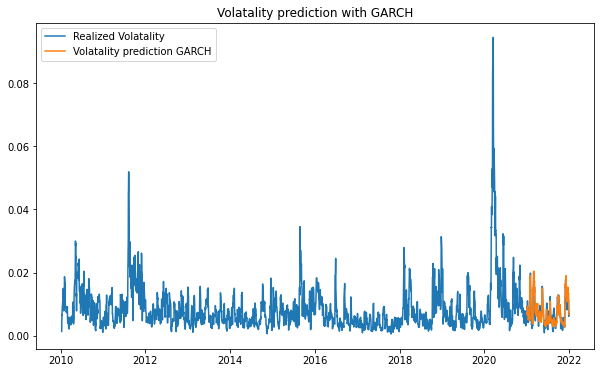

In [ ]:
#Plotting our volatality predictions aginst the realized volatality
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(forecast_garch.variance.iloc[-len(split_date):]/100, label = "Volatality prediction GARCH")
plt.title("Volatality prediction with GARCH", fontsize = 12)
plt.legend()

Hence we see that the voaltality of returns are well fitted by GARCH since GARCH does not assume that the returns are independent , it can account for their leptokurtic properties.But GARCH is not able to model the asymmetric response of the shock.
To fix this issue , we further use an improved model, namely:
#GJR-GARCH Model

We will once again use the Bayesian Information Criteria to model our GJR-GARCH model

In [ ]:
bic_gjr_garch = []
for p in range(1,5):
  for q in range(1,5):
    gjr_garch = arch_model(ret, mean = "zero", p =p, q = q, o = 1).fit(disp = "off")
    bic_gjr_garch.append(gjr_garch.bic)
    if gjr_garch.bic == np.min(bic_gjr_garch):
      best_params = p,q
gjr_garch = arch_model(ret, mean = "zero", p = best_params[0], q = best_params[1], o = 1).fit(disp = "off")
print(gjr_garch.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3711.72
Distribution:                  Normal   AIC:                           7431.45
Method:            Maximum Likelihood   BIC:                           7455.50
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:22   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0441  7.691e-03      5.731  9.958e-09 

In [ ]:
forecast = gjr_garch.forecast(start = split_date[0])
forecast_gjgarch = forecast

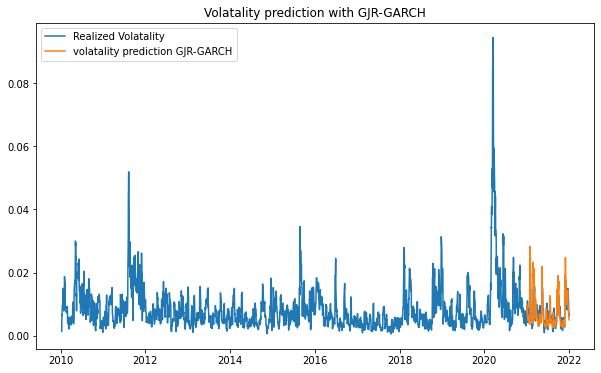

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(forecast_gjgarch.variance.iloc[-len(split_date):]/100, label = "volatality prediction GJR-GARCH")
plt.title("Volatality prediction with GJR-GARCH")
plt.legend();

Now we will talk about another model which accounts for asymmetric announcements. But unlike GJR-GARCH model here, we dont need to take care of negative volTlity. This model is namely:
# EGARCH Model:

We will use the similar Bayesian Information Criteria to find the best lags for our EGARCH Model

In [ ]:
bic_egarch = []
for p in range(1,5):
  for q in range(1,5):
    egarch = arch_model(ret,mean = "zero", vol = "EGARCH", p = p, q= q).fit(disp = "off")
    bic_egarch.append(egarch.bic)
    if egarch.bic == np.min(bic_egarch):
      best_params = p,q
egarch = arch_model(ret, mean = "zero", vol = "EGARCH", p = best_params[0], q = best_params[1]).fit(disp = "off")
egarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - EGARCH Model Results                       
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3800.26
Distribution:                  Normal   AIC:                           7606.52
Method:            Maximum Likelihood   BIC:                           7624.56
                                        No. Observations:                 3020
Date:                Sat, Oct 15 2022   Df Residuals:                     3020
Time:                        04:48:24   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3673e-03  6.726e-03      0.203      0.839 [-1.182e-02,1.455e-02]
alpha[1]       0.3278  3.360e-02      9.757  1.725e-22      [  0.262,  0.394]
beta[1]        0.9436  1.158e-02     81.456      0.000      [  0.921,  0.966]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
forecast = egarch.forecast(start = split_date[0])
forecast_egarch = forecast

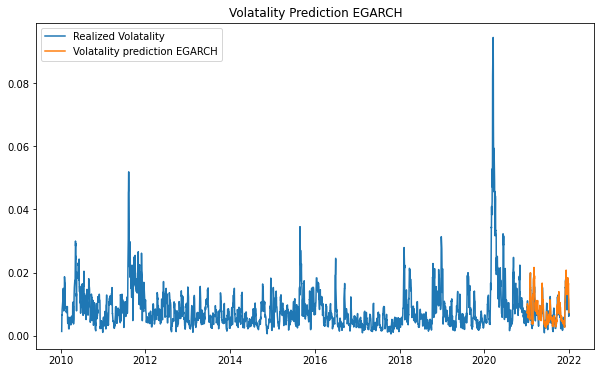

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(forecast_egarch.variance.iloc[-len(split_date):]/100, label = "Volatality prediction EGARCH")
plt.title("Volatality Prediction EGARCH", fontsize = 12)
plt.legend();

Now we will create a function to calculate the root mean squared error of our various models in order to compare our built models.

In [ ]:
def calculate_rmse(model_forecast):
  rmse = np.sqrt(mse(realized_vol[-n:]/100,np.sqrt(model_forecast.variance.iloc[-len(split_date):]/100)))
  return rmse

In [ ]:
rmse_list = []
rmse_list.append(calculate_rmse(forecast_arch))
rmse_list.append(calculate_rmse(forecast_garch))
rmse_list.append(calculate_rmse(forecast_gjgarch))
rmse_list.append(calculate_rmse(forecast_egarch))
rmse_list

[0.0814085262386102,
 0.07841934783565697,
 0.07790709848155851,
 0.08162322283016318]

In [ ]:
names = ["ARCH","GARCH","GJR-GARCH","EGARCH"]

In [ ]:
error = pd.DataFrame(rmse_list)
error.index = names

In [ ]:
error.rename(columns = {"0":"RMSE"})
error


,0
ARCH,0.081409
GARCH,0.078419
GJR-GARCH,0.077907
EGARCH,0.081623


# Now we will see how machine learning can be used to model volatality.We will apply the concept of Support Vector Machines to our GARCH model.
#SVR-GARCH Model

In order to make our data linearly separable , we can use kernel functions:

In [ ]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop = True, inplace = True)

In [ ]:
returns_svm = ret**2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [ ]:
X= pd.concat([realized_vol,returns_svm],axis = 1, ignore_index = True)
X= X[4:].copy()
X =  X.reset_index()
X.drop('index',axis = 1, inplace = True)

In [ ]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis = 1, inplace = True)

In [ ]:
#Creating new variables for each SVR kernel
svr_poly = SVR(kernel = "poly", degree = 2)
svr_lin = SVR(kernel = "linear")
svr_rbf = SVR(kernel = "rbf")

In [ ]:
#Lets run the SVR-GARCH application with linear kernel
#Identify the hyperparameter space for tuning
para_grid = {'gamma': sp_rand(),'C':sp_rand(), 'epsilon': sp_rand()}
#Applying hyperparameter tuning with RnadomizedSearchCV
clf = RandomizedSearchCV(svr_lin,para_grid)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])#predict the volatalities of last 252 observations

In [ ]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:]/100, predict_svr_lin/100))
print("The RMSE value of SVR with linear kernel is:{}".format(rmse_svr))
predict_svr_lin.index = ret.iloc[-n:].index
realized_vol.index = ret.iloc[4:].index

The RMSE value of SVR with linear kernel is:0.00043275194073773195


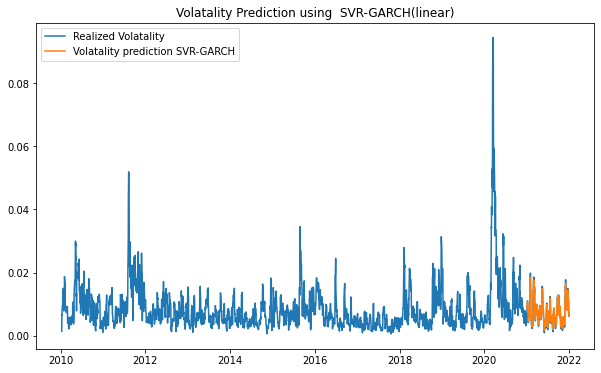

In [ ]:
#Plotting our predictions
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(predict_svr_lin/100,label = "Volatality prediction SVR-GARCH" )
plt.title("Volatality Prediction using  SVR-GARCH(linear)", fontsize = 12)
plt.legend();

Now we will use the rbf Kernel to design our SVR-GARCH model

In [ ]:
para_grid = {'gamma':sp_rand(), "C":sp_rand(),"epsilon":sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [ ]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index
remse_svr = np.sqrt(mse(realized_vol.iloc[-n:]/100,predict_svr_rbf/100))
print("The RMSE for SVR-GARCH model with rbf kernel is :{}".format(rmse_svr))


The RMSE for SVR-GARCH model with rbf kernel is :0.00043275194073773195


In [ ]:
realized_vol.index = ret.iloc[4:].index

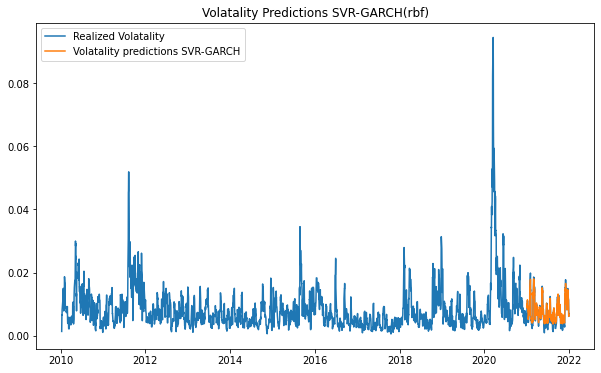

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100,label = "Realized Volatality")
plt.plot(predict_svr_rbf/100,label = "Volatality predictions SVR-GARCH")
plt.title("Volatality Predictions SVR-GARCH(rbf)")
plt.legend();

Making model with our polynomial kernel

In [64]:
para_grid = {"gamma":sp_rand(),"C":sp_rand(),"epsilon":sp_rand()}
clf = RandomizedSearchCV(svr_poly,para_grid)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [66]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:]/100,predict_svr_poly/100))
realized_vol.index = ret.iloc[4:].index
print("The RMSE value for the SVR-GARCH model with polynomila kernel is :{}".format(rmse_svr))


The RMSE value for the SVR-GARCH model with polynomila kernel is :0.003056314777394194


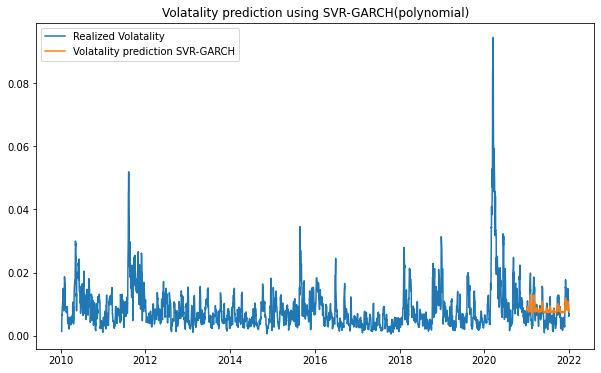

In [68]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol/100,label = "Realized Volatality")
plt.plot(predict_svr_poly/100, label = "Volatality prediction SVR-GARCH")
plt.title("Volatality prediction using SVR-GARCH(polynomial)")
plt.legend();

Now we are going to predict the volatality of our dataset using:
#Neural Networks

In [70]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init = 0.001, random_state = 1)
para_grid_nn = {'hidden_layer_sizes':[(100,50),(50,50),(10,100)],'max_iter':[500,1000],'alpha':[0.00005,0.0005]}
clf = RandomizedSearchCV(NN_vol,para_grid_nn)
clf.fit(X.iloc[:-n].values, realized_vol[1:-(n-1)].values.reshape(-1,))
NN_predictions = clf.predict(X.iloc[-n:])

In [74]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index
rmse_nn = np.sqrt(mse(realized_vol.iloc[-n:]/100,NN_predictions/100))
print("The RMSE of our neural network model is:{}".format(rmse_nn))
realized_vol.index = ret.iloc[4:].index

The RMSE of our neural network model is:0.0004866223062666413


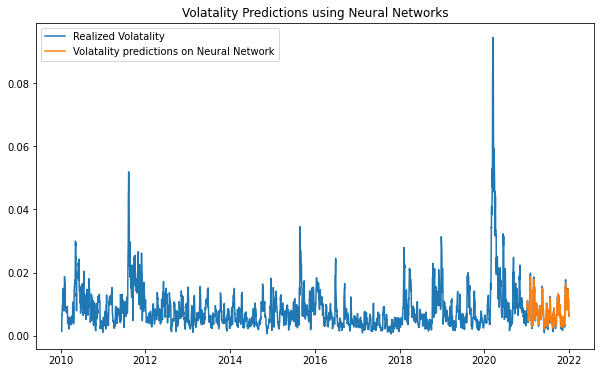

In [72]:
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100,label = "Realized Volatality")
plt.plot(NN_predictions/100, label = "Volatality predictions on Neural Network")
plt.title("Volatality Predictions using Neural Networks")
plt.legend();

# The Bayesian Approach
We will use the Bayesian technique of Metropolis-Hastings to model our volatality of stocks now 

In [78]:
pip install git+https://github.com/RJT1990/pyflux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-0cbrxqj0
  Running command git clone -q https://github.com/RJT1990/pyflux /tmp/pip-req-build-0cbrxqj0
  Created wheel for pyflux: filename=pyflux-0.4.17-cp37-cp37m-linux_x86_64.whl size=5241969 sha256=167225c518eef9db990636dc881b2b7b534e31b817a10326ec07ac7b993f02df
  Stored in directory: /tmp/pip-ephem-wheel-cache-7fd2cil7/wheels/96/8f/9c/4523f6aab114103428254ec8f7260d52bffaa1ea1add77a487
Successfully built pyflux


In [79]:
import pyflux as pf
from scipy.stats import kurtosis

In [80]:
model = pf.GARCH(ret.values, p = 1, q = 1)
print(model.latent_variables)
model.adjust_prior(1,pf.Normal())
model.adjust_prior(2,pf.Normal())
x = model.fit(method = 'M-H',iterations = '1000')
x.summary()

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      
Acceptance rate of Metropolis-Hastings is 0.11145
Acceptance rate of Metropolis-Hastings is 0.1772
Acceptance rate of Metropolis-Hastings is 0.2555

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.253425
GARCH(1,1)                                                                                                
======================================================= ============

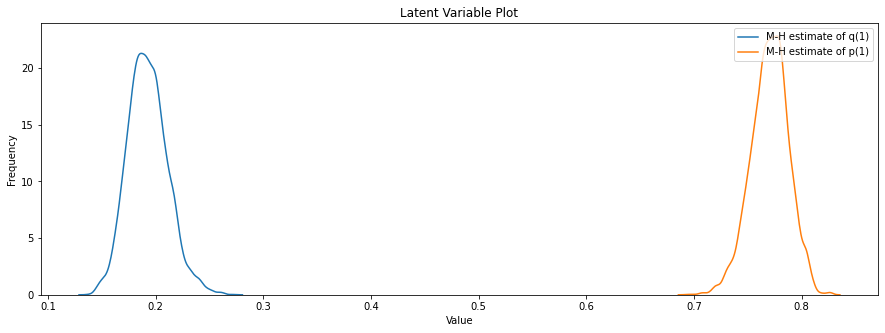

In [82]:
model.plot_z([1,2])#Plotting the latent variables


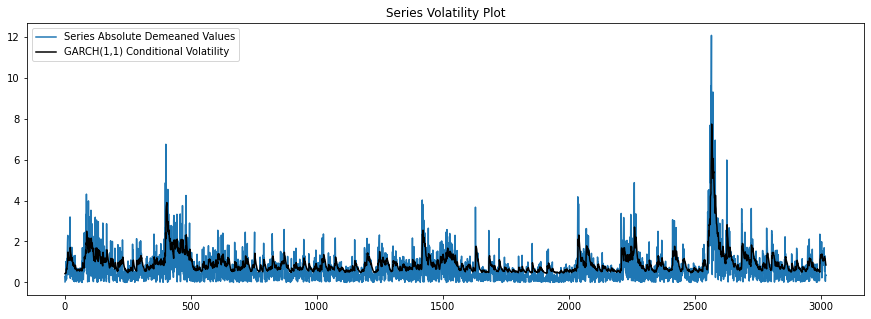

In [83]:
model.plot_fit(figsize = (15,5))#Plotting the fitted Model


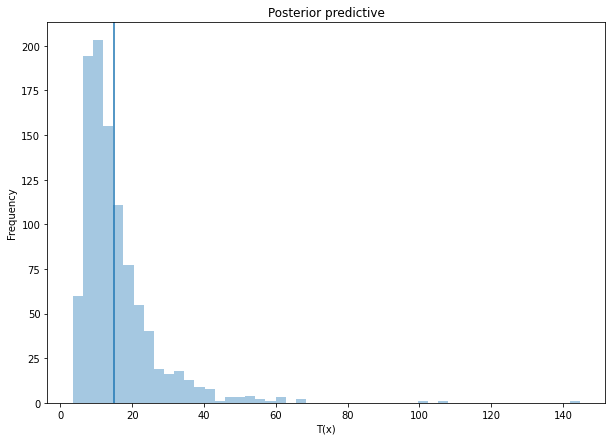

In [84]:
model.plot_ppc(T = kurtosis, nsims = 1000)#Plotting the histogram of posterior check

In [85]:
bayesian_prediction = model.predict_is(n,fit_methods = 'M-H')#In sample volatality prediction

In [86]:
bayesian_RMSE=np.sqrt(mse(realized_vol.iloc[-n:]/100,bayesian_prediction.values/100))
print("The RMSE of our Bayesian Prediction Model is:{}".format(bayesian_RMSE))

The RMSE of our Bayesian Prediction Model is:0.0024712932538041034


In [87]:
bayesian_prediction.index = ret.iloc[-n:].index

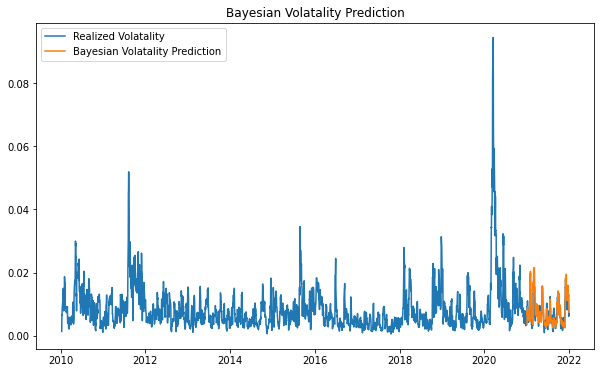

In [88]:
plt.figure(figsize = (10,6))
plt.plot(realized_vol/100, label = "Realized Volatality")
plt.plot(bayesian_prediction/100,label = "Bayesian Volatality Prediction")
plt.title("Bayesian Volatality Prediction", fontsize = 12)
plt.legend();